In [54]:
import torch, torchaudio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(str(torchaudio.list_audio_backends()))

['soundfile']


Shape of waveform: torch.Size([1, 179712])
Sample rate of waveform: 44100


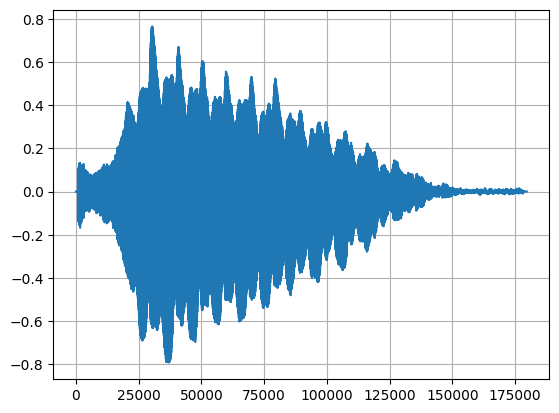

In [105]:
filename = "skr1.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.grid()
plt.plot(waveform.t().numpy())

Shape of spectrogram: torch.Size([1, 201, 899])


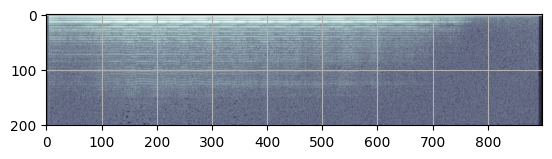

In [106]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.grid()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='bone')

Shape of spectrogram: torch.Size([1, 128, 899])


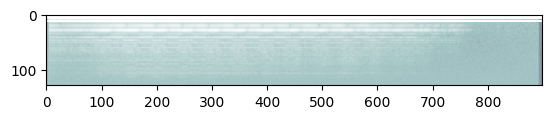

In [52]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='bone')

Shape of transformed waveform: torch.Size([1, 17972])


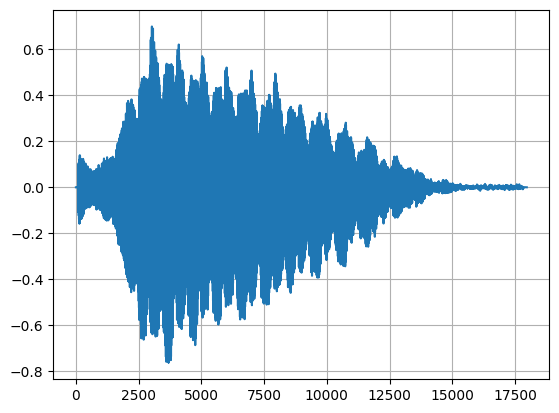

In [45]:
new_sample_rate = sample_rate/10

# Since Resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.grid()
plt.plot(transformed[0,:].numpy())

In [46]:
# Let's check if the tensor is in the interval [-1,1]
print("Min of waveform: {}\nMax of waveform: {}\nMean of waveform: {}".format(waveform.min(), waveform.max(), waveform.mean()))

Min of waveform: -0.791748046875
Max of waveform: 0.7646484375
Mean of waveform: -2.3378265723295044e-06


In [47]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# Let's normalize to the full interval [-1,1]
waveform = normalize(waveform)

Shape of transformed waveform: torch.Size([1, 179712])


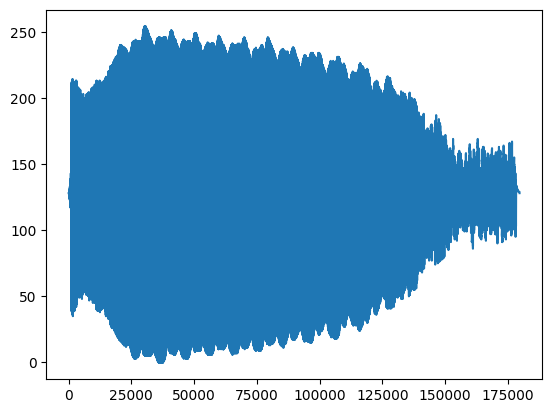

In [48]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

Shape of recovered waveform: torch.Size([1, 179712])


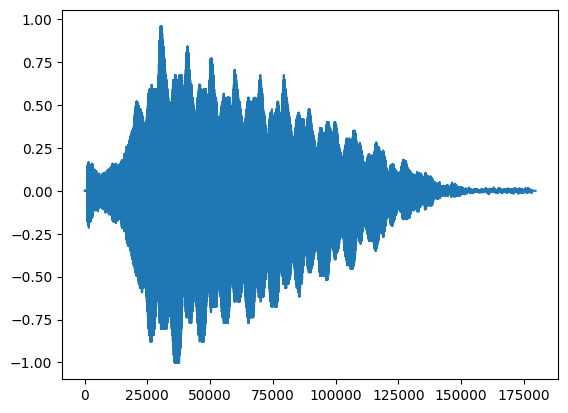

In [49]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy())

In [50]:
# Compute median relative difference
err = ((waveform-reconstructed).abs() / waveform.abs()).median()

print("Median relative difference between original and MuLaw reconstucted signals: {:.2%}".format(err))

Median relative difference between original and MuLaw reconstucted signals: 1.30%


In [58]:
# !pip install librosa
import librosa

In [98]:
y, sr = librosa.load('DeLangsteNacht.wav')

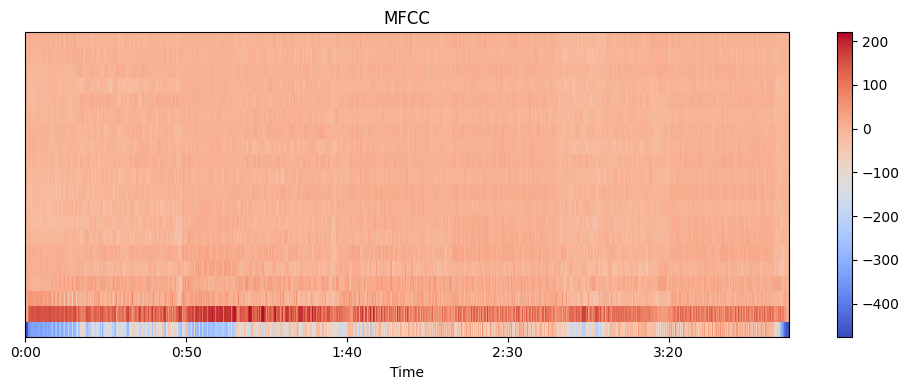

In [99]:
import librosa.display

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr)

# Display the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
# plt.savefig("./output/Plot.png")
plt.show()

In [100]:
import scipy
from scipy.signal.windows import hann 
scipy.signal.hann = hann # very durty hack

# Estimate the tempo and beat events
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

print(f"Estimated Tempo: {tempo} BPM")
print("Beat Frames:", beats)

Estimated Tempo: 117.45383522727273 BPM
Beat Frames: [  621   642   663   685   706   728   750   771   792   814   836   858
   880   900   922   944   965   987  1009  1030  1051  1073  1095  1116
  1138  1159  1180  1200  1221  1243  1265  1287  1308  1329  1352  1374
  1394  1416  1438  1459  1481  1503  1524  1545  1566  1588  1610  1631
  1651  1670  1688  1707  1728  1747  1771  1793  1815  1836  1858  1879
  1900  1921  1943  1965  1987  2008  2029  2050  2072  2094  2116  2137
  2159  2180  2201  2223  2244  2266  2287  2309  2331  2352  2374  2395
  2417  2438  2460  2481  2503  2524  2546  2568  2589  2611  2632  2654
  2675  2697  2718  2740  2761  2783  2804  2826  2848  2869  2891  2912
  2934  2955  2977  2998  3020  3042  3063  3085  3106  3128  3149  3171
  3192  3214  3235  3257  3278  3300  3322  3343  3364  3386  3408  3429
  3451  3472  3494  3515  3537  3558  3580  3601  3623  3645  3666  3688
  3709  3731  3752  3774  3795  3817  3838  3860  3881  3903  3924  394

Обнаружение начала является фундаментальной задачей обработки аудиосигнала, которая включает в себя идентификацию точек в аудиосигнале, где происходят важные события или переходные процессы. Он вычисляет огибающую силы наступления, идентифицирует события начала и визуализирует силу начала и обнаруженные начала на графике. Обнаружение начала имеет важное значение для идентификации важных событий в аудиосигнале, таких как удары и начало нот. Полученный график позволяет наблюдать за ритмическими рисунками и изменениями интенсивности звука.

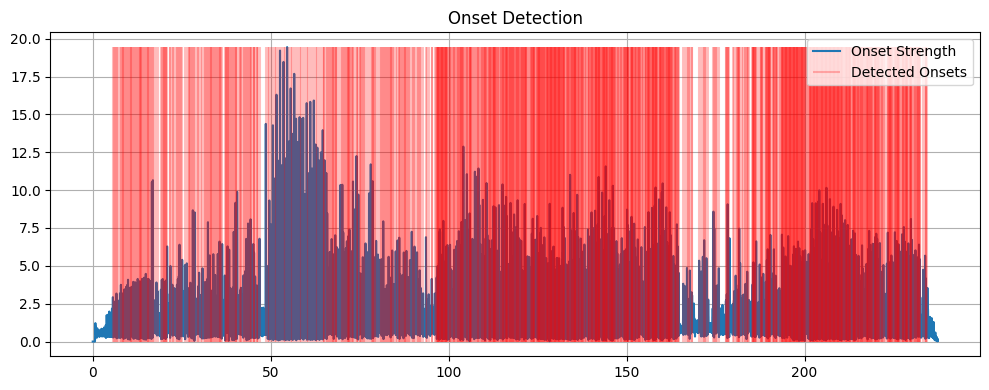

In [101]:
# Compute onset strength envelope
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Find onset events
onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)

# Plot the onset strength envelope and detected onsets
plt.figure(figsize=(10, 4))
plt.plot(librosa.times_like(onset_env), onset_env, label='Onset Strength')
plt.vlines(librosa.times_like(onset_env)[onsets], 0, onset_env.max(), color='r', alpha=0.25, label='Detected Onsets')
plt.legend()
plt.title('Onset Detection')
plt.tight_layout()
plt.grid()
plt.show()

Константно-добротное преобразование (CQT) — это частотно-временное представление, аппроксимирующее слуховое восприятие высоты звука человеком. Он особенно полезен для анализа музыкальных аудиосигналов и применяется в транскрипции, оценке высоты тона и задачах анализа музыки.

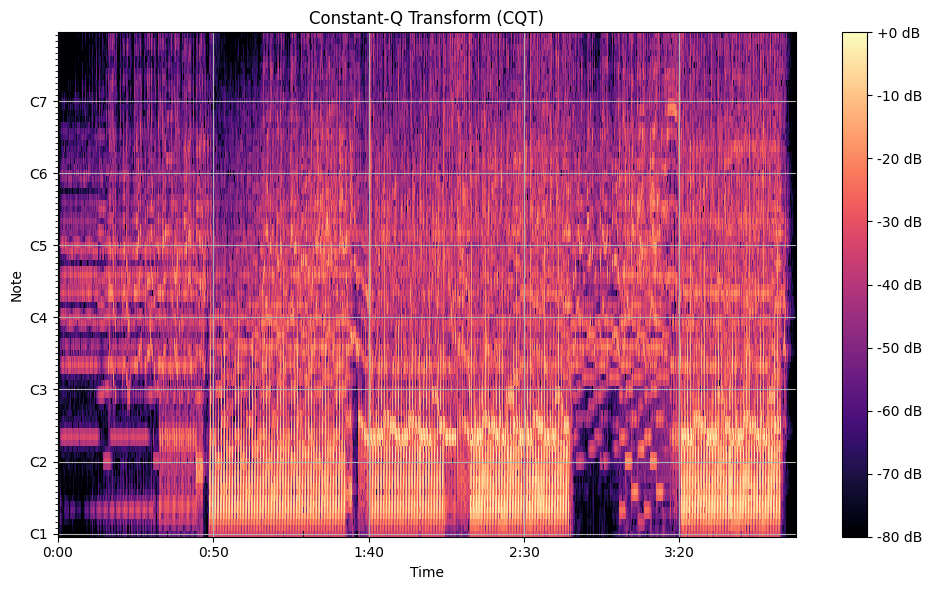

In [102]:
# Load the built-in "jazz" audio file
audio, sr = librosa.load('DeLangsteNacht.wav')#(librosa.example('trumpet'))

# Compute the CQT representation
cqt = librosa.cqt(audio, sr=sr)

# Display the CQT representation
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(cqt), ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q Transform (CQT)')
plt.tight_layout()
plt.grid()
plt.show()

In [107]:
sample_wav_file = "erika.wav"

waveform, sample_rate = torchaudio.load(sample_wav_file)
print(f"Shape of the waveform: {waveform.size()}\n")
print(f"Sampling rate of the audio file: {sample_rate}")

Shape of the waveform: torch.Size([2, 8876903])

Sampling rate of the audio file: 44100


In [116]:
save_path = "save_erika.wav" 
# torchaudio.save(save_path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16, format="wav")
torchaudio.save(save_path, waveform, sample_rate, bits_per_sample=8, format="wav")

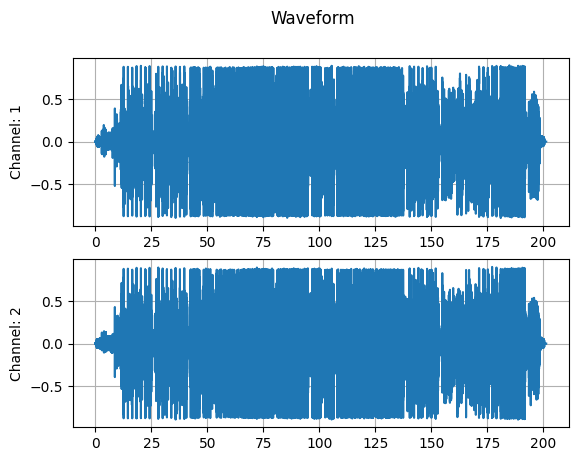

In [117]:
def plot_waveform(waveform, sample_rate, title = "Waveform"):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  time = np.arange(0, num_frames) / sample_rate

  fig, axes = plt.subplots(num_channels, 1)
  
  if num_channels == 1:
    axes = [axes]
  for ch in range(num_channels):
    axes[ch].plot(time, waveform[ch])
    axes[ch].grid(True)

    if num_channels > 1:
      axes[ch].set_ylabel(f"Channel: {ch+1}")
  plt.suptitle(title)
  plt.show(block = False)

plot_waveform(waveform, sample_rate)

Спектрограмма — это визуальное представление частотного состава звукового сигнала во времени. Спектрограмма вычисляется путем применения преобразования Фурье к осциллограмме.
Например, для создания спектрограммы аудиосэмпла с помощью torchaudio можно использовать преобразование «Спектрограмма» из модуля torchaudio.transforms.
torchaudio.transform.Spectrogram принимает следующие аргументы:
n_fft - Определяет размер быстрого преобразования Фурье.
hop_length - Длина перехода между короткими окнами преобразования Фурье.
center - Заполняет осциллограмму с обеих сторон таким образом, чтобы t-й кадр был центрирован в точке t x hop_length.
pad_mode = Управляет методом заполнения, используемым, когда center имеет значение True.

In [118]:
n_fft = 1024
hop_length = 512

spectrogram = T.Spectrogram(n_fft=n_fft,
                            hop_length=hop_length,
                            center=True,
                            pad_mode="reflect",
                            power=2.0)
spec = spectrogram(waveform)

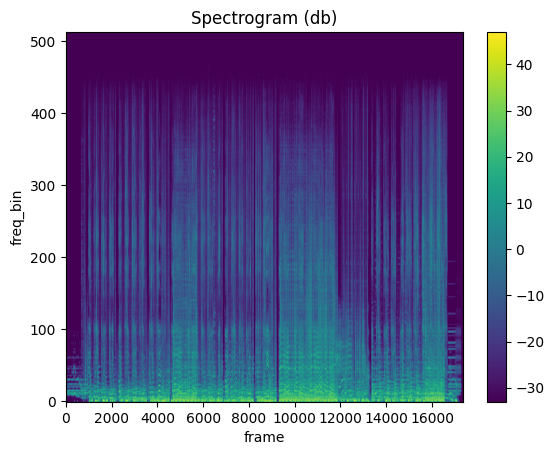

In [119]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

plot_spectrogram(spec[0])

Мел-спектрограмма — это спектрограмма, которая была преобразована с использованием меловой частотной шкалы, которая более тесно связана с человеческим восприятием высоты тона, чем линейная шкала частот.
Для создания спектрограммы mel с помощью torchaudio можно использовать преобразование MelSpectrogram из модуля torchaudio.transforms. Преобразование MelSpectrogram принимает форму волны звукового образца в качестве входных данных и возвращает тензор, представляющий mel-спектрограмму аудиосэмпла.

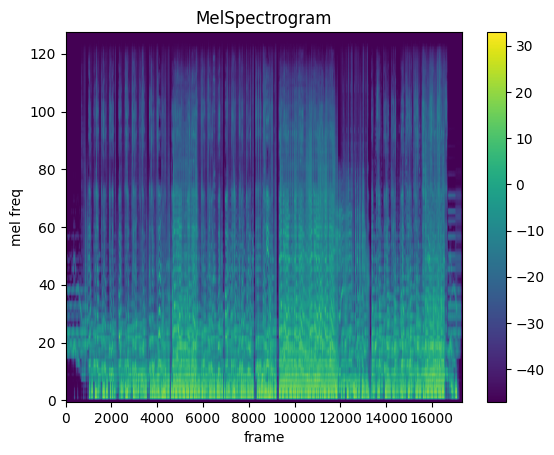

In [121]:
n_fft = 1024
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   center=True,
                                   pad_mode="reflect",
                                   power=2.0,
                                   norm='slaney',
                                   #onesided=True,
                                   n_mels=n_mels,
                                   mel_scale="htk")

melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec[0], title="MelSpectrogram", ylabel='mel freq')

Часто бывает полезно восстановить исходную форму звукового образца из его спектрограммы.  


Одним из методов для этого является алгоритм Гриффина-Лима, который итеративно реконструирует форму сигнала по спектрограмме с использованием аппроксимации спектральной величины. Например, для восстановления осциллограммы из спектрограммы с помощью алгоритма Гриффина-Лима в torchaudio можно использовать преобразование GriffinLim из модуля torchaudio.transforms.


Алгоритм Гриффина-Лима (GLA), метод фазовой реконструкции, основан на избыточности, присущей кратковременному преобразованию Фурье. Повторение двух проекций помогает обеспечить согласованность спектрограммы; спектрограмма считается согласованной, когда сохраняется ее межбункерная зависимость, возникающая в результате избыточности STFT. GLA основана только на согласованности и игнорирует предварительную информацию о целевом сигнале. Преобразование GriffinLim принимает спектрограмму аудиосэмпла в качестве входных данных и возвращает восстановленную форму волны аудиосэмпла.

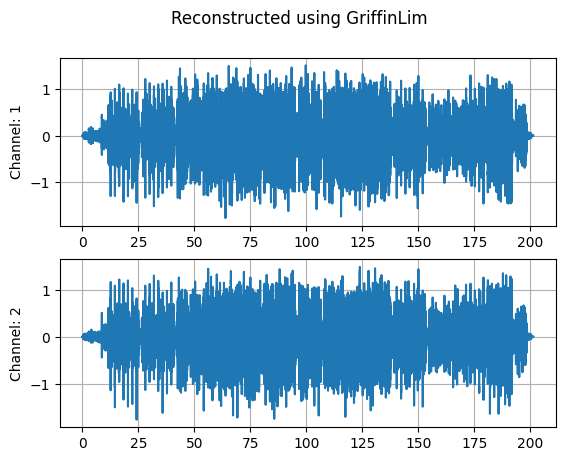

In [122]:
n_fft = 1024
hop_length = 512


griffin_lim = T.GriffinLim(n_fft=n_fft,
                           hop_length=hop_length)

waveform = griffin_lim(spec)
plot_waveform(waveform, sample_rate, title = "Reconstructed using GriffinLim")

In [123]:
save_path = "Reconstructed_using_GriffinLim.wav" 
# torchaudio.save(save_path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16, format="wav")
torchaudio.save(save_path, waveform, sample_rate, bits_per_sample=8, format="wav")

Извлечение признаков — это извлечение релевантных признаков или характеристик из необработанных данных, которые можно использовать в качестве входных данных для модели машинного обучения. 


Например, в контексте аудиоданных это может включать извлечение из аудиосигнала таких признаков, как спектральные характеристики, высота тона или громкость. TorchAudio предоставляет 2 модуля: torchaudio.functional и torchaudio.transforms. Функциональный модуль реализует функции как автономную функцию, в то время как модуль transforms реализует функции объектно-ориентированным образом. 

Банк фильтров Mel представляет собой набор фильтров, разлагающих аудиосигнал на ряд частотных диапазонов.


Каждый фильтр в банке фильтров предназначен для пропускания определенного диапазона частот и ослабления всех остальных частот.


Они особенно полезны для задач, связанных с моделированием спектральных характеристик звукового сигнала, так как позволяют представить сигнал в компактном и содержательном виде.


Мы используем torchaudio.functional.melscale_fbanks. Эта функция не требует входного аудио и возвращает треугольные банки фильтров размером (n_freqs, n_mels). Функция принимает следующие аргументы: n_freqs - Количество частот для выделения/применения. f_min - Минимальная частота f_max - Максимальная частота norm - Если slaney, разделите треугольные веса mel на ширину полосы mel.

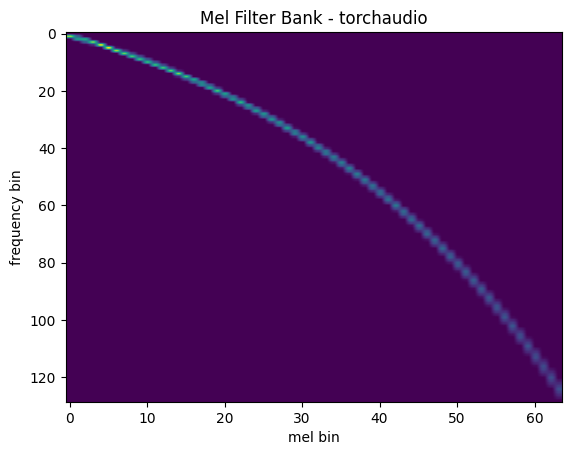

In [125]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney")

def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

Мел-частотные цепстральные коэффициенты (MFCC) — это общее представление спектральной огибающей звука, которое описывает, как мощность звука распределяется по различным частотам. Преобразование MFCC реализовано в torchaudio.transforms.MFCC, этот класс принимает следующие аргументы: n_mfcc - Количество коэффициентов MFC, сохраняемых после преобразования. melkwargs - Это аргументы для создания MelSpectrogram.

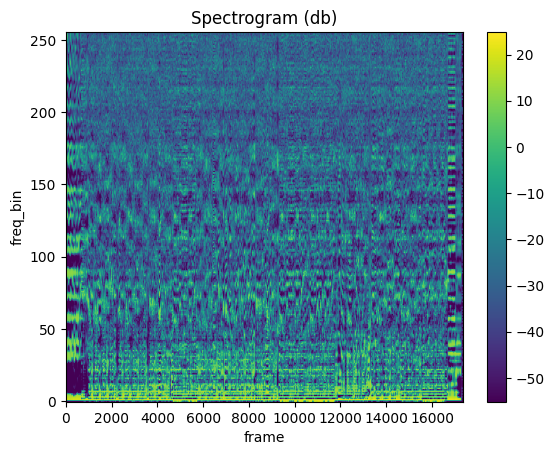

In [126]:
n_fft = 2048
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(sample_rate=sample_rate,
                        n_mfcc=n_mfcc,
                        melkwargs={"n_fft": n_fft,
                                   "n_mels": n_mels,
                                   "hop_length": hop_length,
                                   "mel_scale": "htk"})

mfcc = mfcc_transform(waveform)
plot_spectrogram(mfcc[0])

Логарифмические частотные цепстральные коэффициенты (LFCC) — это вариант MFCC, который во многом похож, но вместо использования линейной шкалы частот используется логарифмическая шкала частот. В torchaudio преобразование LFCC реализовано в классе torchaudio.transforms.LFCC. Этот класс имеет API, аналогичный преобразованию MFCC, и принимает в качестве входных данных 1D- или 2D-тензор, представляющий сигнал или пакет сигналов, и возвращает 2D-тензор LFCC. Кроме того, преобразование имеет несколько необязательных аргументов, которые позволяют настроить поведение вычисления LFCC.

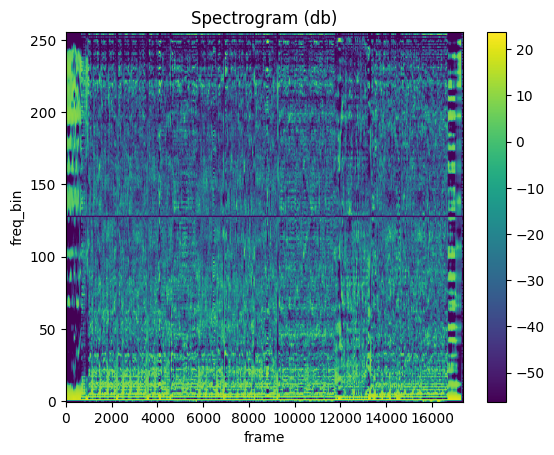

In [127]:
n_fft = 2048
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(sample_rate=sample_rate,
                        n_lfcc=n_lfcc,
                        speckwargs={"n_fft": n_fft,
                                    "hop_length": hop_length})

lfcc = lfcc_transform(waveform)
plot_spectrogram(lfcc[0])